In [1]:
import pints
import pints.toy
import pints.emulator as emulator
import pints.emulator.plot as emuplt
import pints.emulator.utils as emutils

import numpy as np
import matplotlib.pyplot as plt
import GPy

import string
from itertools import product

## Specifying model

In [2]:
# Create a model
model = pints.toy.LotkaVolterraModel()

n_parameters = model.n_parameters()
n_outputs = model.n_outputs()

# set parameters
real_parameters = np.array(model.suggested_parameters())

# take times and calculate values
suggested_times = model.suggested_times()
min_time, max_time = min(suggested_times), max(suggested_times)
n_splits = 200 
times = np.linspace(min_time, max_time, n_splits)

# simulate
org_values = model.simulate(real_parameters, times)

# noise
# by default set 5% of range as the standard deviation 
range_percent = 0.05
noise_stds = (org_values.max(axis = 0) - org_values.min(axis = 0)) * 0.05

# final values
values = org_values + np.random.normal(0, noise_stds, org_values.shape)

# Create an object with links to the model and time series
problem = pints.MultiOutputProblem(model, times, values)

# Create a log-likelihood function (adds an extra parameter!)
real_log_likelihood = pints.KnownNoiseLogLikelihood(problem, noise_stds)

print("Number of parameters: ", n_parameters)
print("Parameter values: ", real_parameters)
print("Example problem values:\n", problem.values()[:5])

Number of parameters:  4
Parameter values:  [3 2 3 2]
Example problem values:
 [[1.99485812 1.96356766]
 [1.97159981 2.05673658]
 [1.84352538 1.91316282]
 [1.92293413 1.9588596 ]
 [1.8517477  2.15963108]]


In [3]:
# specify names for each parameter in the model
# default is alphabetical
index_to_param_name = dict(enumerate(string.ascii_lowercase[:n_parameters]))
index_to_param_name

{0: 'a', 1: 'b', 2: 'c', 3: 'd'}

## Creating emulator and specifying variables

In [4]:
# creating distribution on bounds
# by default uniform with +-10% of original values
param_range = 0.1
real_params_lower = (1 - param_range) * real_parameters
real_params_upper = (1 + param_range) * real_parameters

bounds = pints.Boundaries(lower = real_params_lower, upper = real_params_upper)
log_prior = pints.UniformLogPrior(bounds)

print(list(zip(bounds.lower(), bounds.upper())))

[(2.7, 3.3000000000000003), (1.8, 2.2), (2.7, 3.3000000000000003), (1.8, 2.2)]


In [5]:
# training size
training_size = 500

input_parameters = log_prior.sample(training_size)
target_likelihoods = np.apply_along_axis(real_log_likelihood, 1, input_parameters)

emu = emulator.GPEmulator(real_log_likelihood, 
                          input_parameters, 
                          target_likelihoods, 
                          normalize_input = True)

## Visualizing fixed surfaces 

In [6]:
# number of splits for each free parameter
axis_n_splits = 50
# take min, median, and max values to fix parameter
fixed_param_splits = 3

fixed_parameters = []

# fixed values for each of three parameters
# pick two parameters that will remain free, i and j
# then for others split their domain into fixed_splits equal parts
for i in range(n_parameters):
    for j in range(n_parameters):
        if i == j:
            continue
        mid_vals = enumerate( (bounds.lower()+bounds.upper())/2 )
        mid_vals = list(mid_vals)
        mid_vals = [(idx, val) for (idx, val) in mid_vals if idx not in [i, j]] 

        fixed_parameters.append(mid_vals)


fixed_parameters

[[(2, 3.0), (3, 2.0)],
 [(1, 2.0), (3, 2.0)],
 [(1, 2.0), (2, 3.0)],
 [(2, 3.0), (3, 2.0)],
 [(0, 3.0), (3, 2.0)],
 [(0, 3.0), (2, 3.0)],
 [(1, 2.0), (3, 2.0)],
 [(0, 3.0), (3, 2.0)],
 [(0, 3.0), (1, 2.0)],
 [(1, 2.0), (2, 3.0)],
 [(0, 3.0), (2, 3.0)],
 [(0, 3.0), (1, 2.0)]]

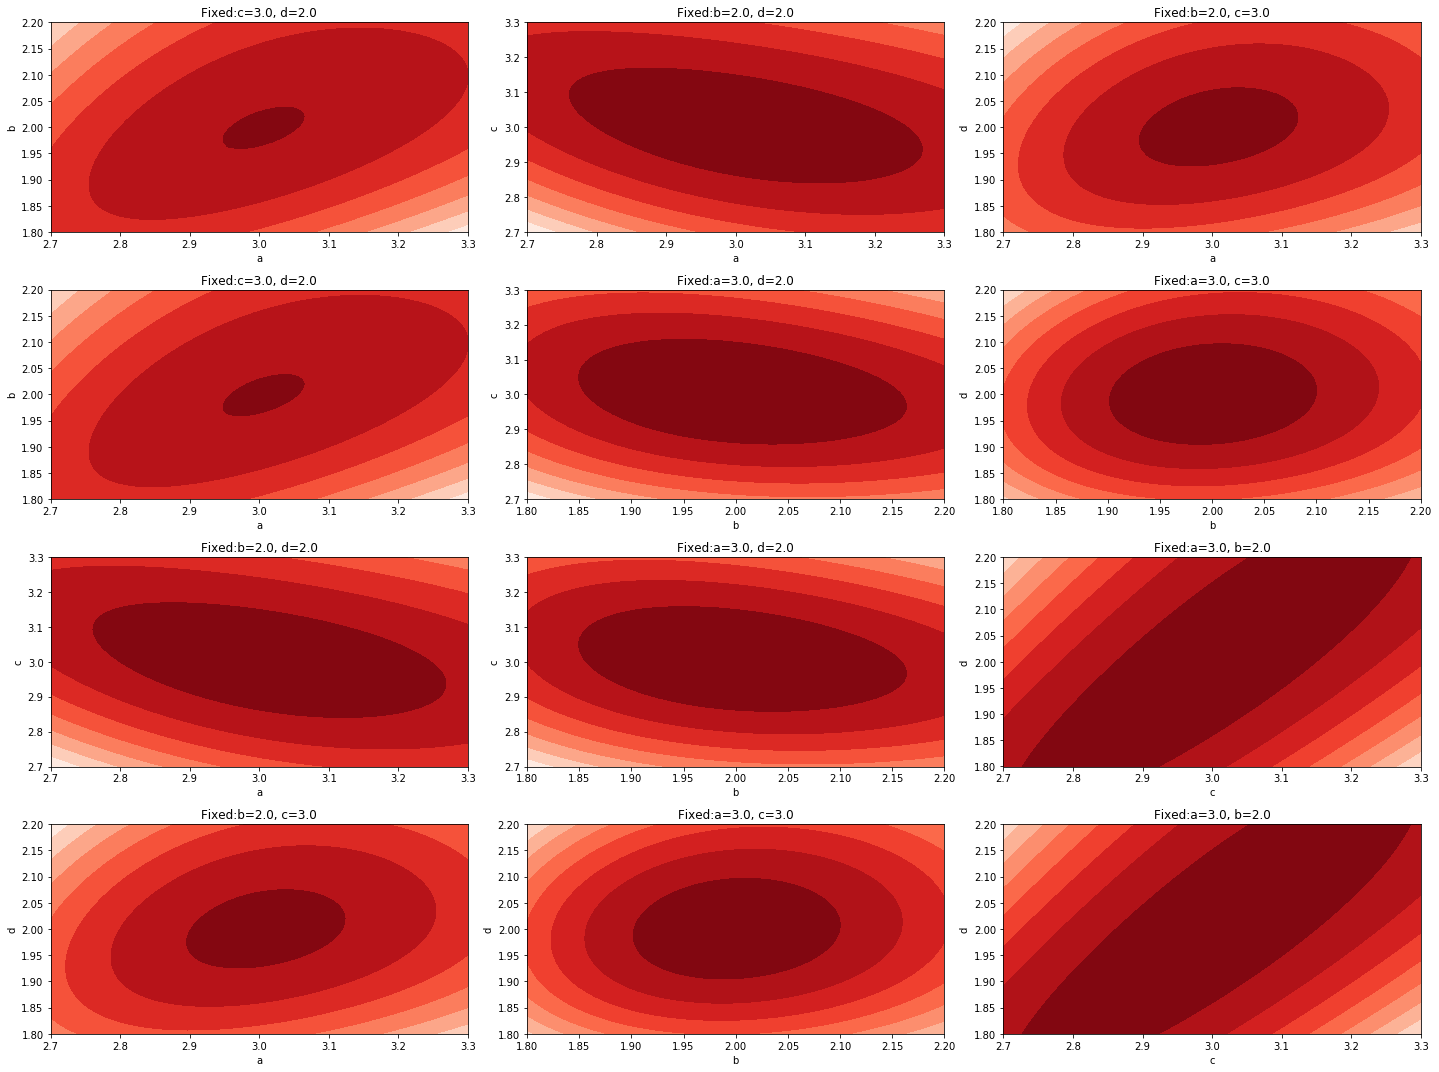

In [7]:
fig, ax = emuplt.plot_fixed_param_grid(
    real_log_likelihood,
    fixed_parameters,
    bounds,
    n_splits = axis_n_splits,
    shape = (n_parameters, n_parameters - 1),
)

plt.show(fig)

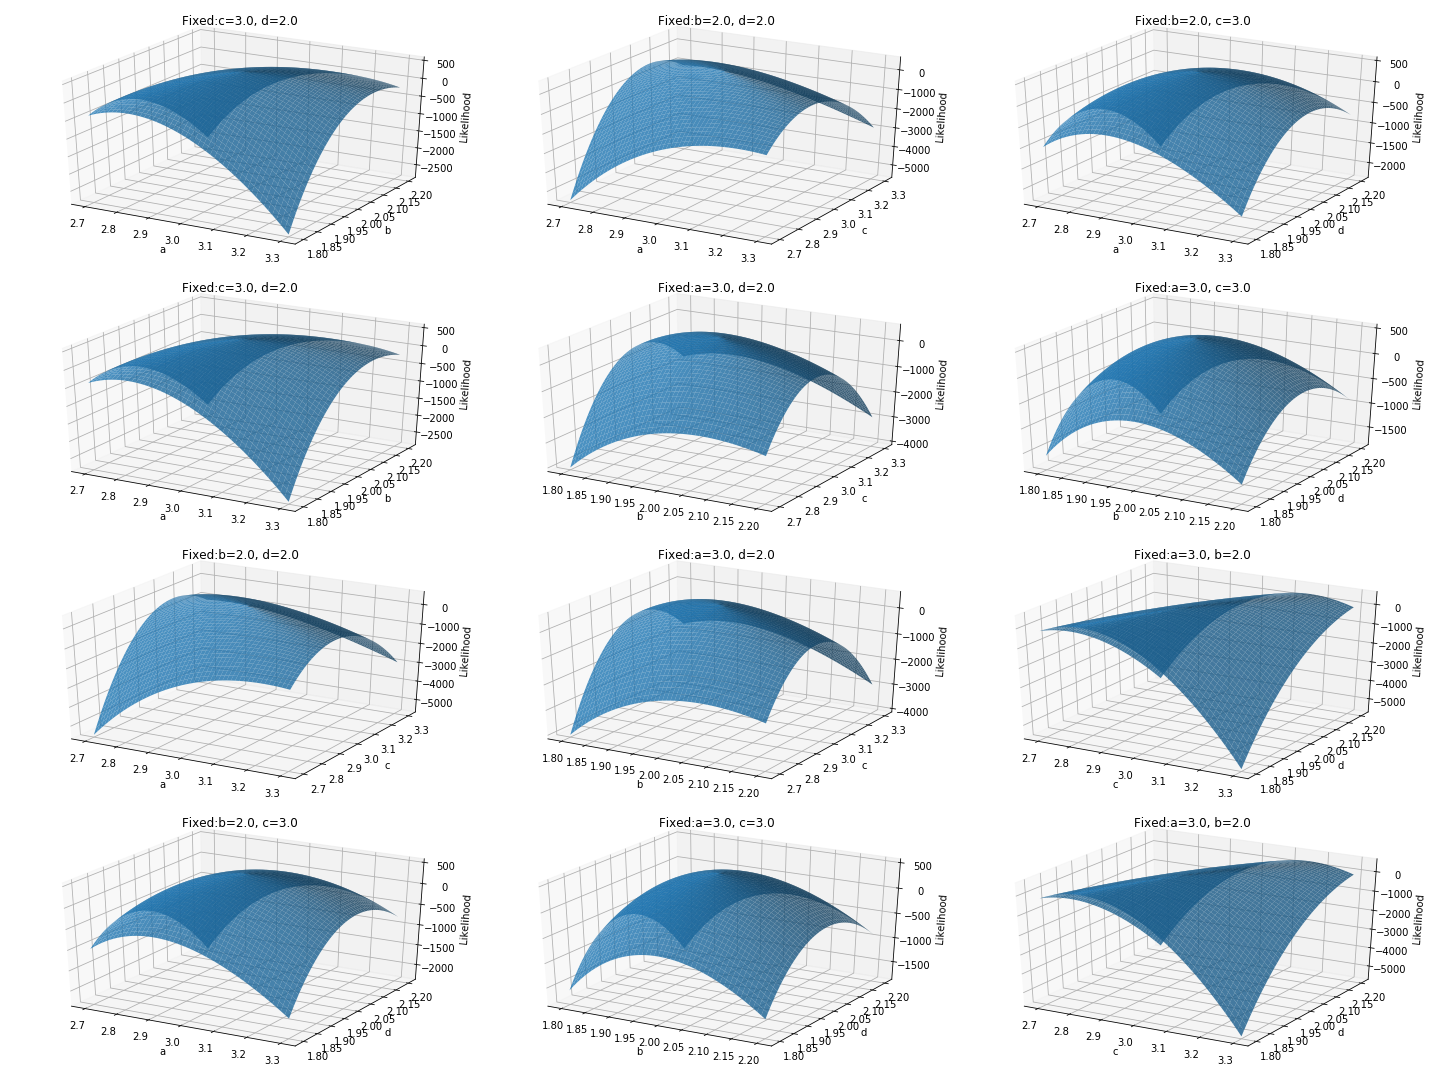

In [8]:
fig, ax = emuplt.plot_fixed_param_grid(
    real_log_likelihood,
    fixed_parameters,
    bounds,
    n_splits = axis_n_splits,
    shape = (n_parameters, n_parameters - 1),
    countour = False
)

plt.show(fig)

## Kernel selection

In [9]:
n_parameters = emu.n_parameters()
kernels = [
    GPy.kern.Linear(n_parameters),
    GPy.kern.Linear(n_parameters) * GPy.kern.Linear(n_parameters),
    GPy.kern.RBF(n_parameters, variance = 0.1),
    GPy.kern.RatQuad(n_parameters, variance = 0.1),
    GPy.kern.MLP(n_parameters),
    GPy.kern.Matern52(n_parameters),
    GPy.kern.RatQuad(n_parameters) + GPy.kern.RBF(n_parameters) * GPy.kern.RBF(n_parameters)
]

kern_names = [
    "Linear",
    "Linear * Linear"
    "RBF",
    "RatQuad",
    "MLP",
    "Matern52",
    "RatQuad + RBF*RBF",
]

# kernels that have been optimized for input data
trained_kernels = []

# possible optimizers: 
# ‘scg’, ‘lbfgs’, ‘tnc’
# can specify max number of iterations using max_iters
optimizer = "lbfgs"
max_iters = 500
emu.set_parameters(optimizer = optimizer)

In [10]:
# when the output data is normalized values of variance should be small
# hence ignore any kernel that has a subkernel 
# (i.e kernel that is a part of sum/product) 
# with variance > 10000
# set avoid_overfitting to False to stop this effect
avoid_overfitting = True
variance_threshold = 10000

In [11]:
marginal_likelihoods = []

for kernel, kernel_name in zip(kernels, kern_names):
    emu.set_parameters(kernel = kernel)
    emu.fit(optimize = False, normalizer = True)
    emu.optimize(max_iters = max_iters, messages = False)
    
    trained_kernel = emu.get_trained_kern()
    trained_kernels.append(trained_kernel)
    
    ml = emu.get_log_marginal_likelihood()
    marginal_likelihoods.append(ml)
    print("{}: {:.2f}".format(kernel_name, ml))

Linear: -707.79
Linear * LinearRBF: -401.97
RatQuad: 2904.51
MLP: 2965.87
Matern52: 2842.81
RatQuad + RBF*RBF: 1920.27


In [13]:
best_kernel = None
best_score = -1 << 31

# find kernel with highest log marginal likelihood
for kernel, score in zip(trained_kernels, marginal_likelihoods):
    # ignore any overfitting kernel
    if avoid_overfitting and emutils.has_high_variance(kernel, threshold = variance_threshold):
        continue
    if score > best_score:
        best_kernel = kernel
        score = best_score
        
best_kernel

rbf.,value,constraints,priors
variance,1813.3200822348972,+ve,
lengthscale,6.6864656598051715,+ve,


In [14]:
# when a kernel consists of many additions / multiplications
# utils method kernel_to_string can be useful
print(emutils.kernel_to_string(best_kernel))

RBF(1813.320082,6.686466)


In [15]:
# TODO: directly assign kernel to GP in class
emu.set_parameters(kernel = best_kernel)
emu.fit(optimize = False, normalizer = True)
emu.optimize(max_iters = max_iters, messages = False)

 /anaconda3/lib/python3.6/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


 /Users/maksympetyak/Prog/pints/pints/emulator/_gp_emulator.py:58: UserWarning:Non-negative log_likelihood predicted. Indicative of high uncertainty in predictions.


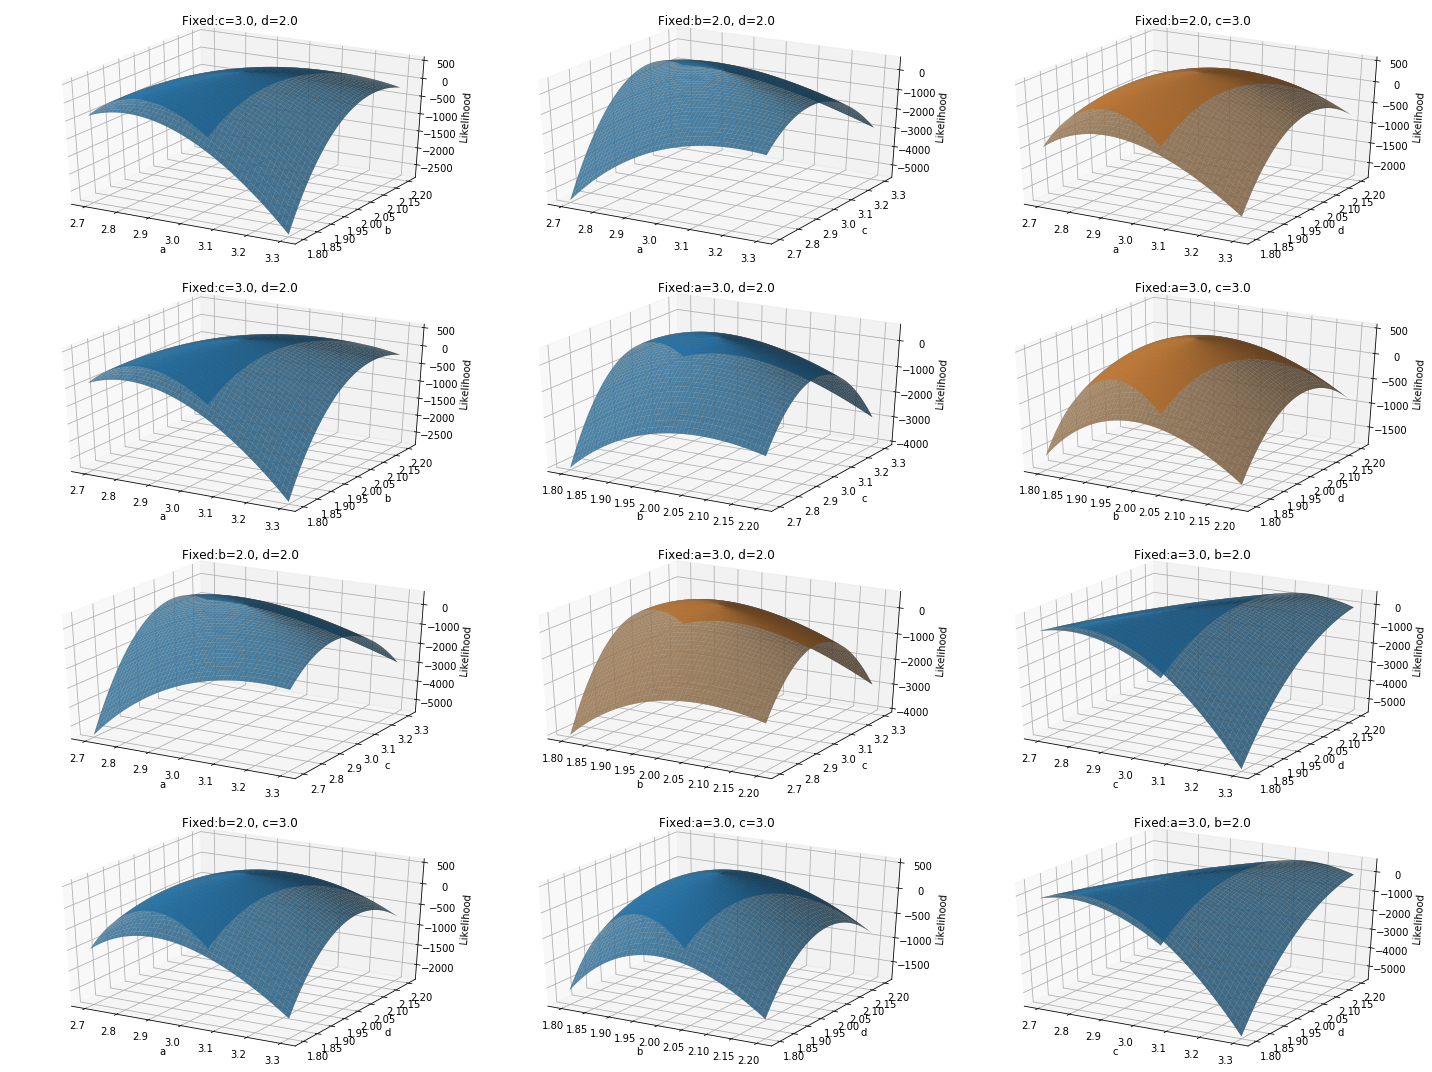

In [16]:
fig, ax = emuplt.plot_fixed_param_grid(
    emu,
    fixed_parameters,
    bounds,
    n_splits = axis_n_splits,
    shape = (n_parameters, n_parameters - 1),
    countour = False,
    additional_log_likelihoods = [real_log_likelihood]
)

plt.show(fig)

## Running and Timing MCMC

In [17]:
# MCMC parameters
mcmc_method = pints.PopulationMCMC
num_chains = 3
mcmc_max_iters = 20000

In [18]:
emu_posterior = pints.LogPosterior(emu, log_prior)
model_posterior = pints.LogPosterior(real_log_likelihood, log_prior)

In [19]:
# possible parameter starting points
# use three chains

xs = [
    real_parameters * 0.95,
    real_parameters * 0.90,
    real_parameters * 1.05,
]

In [20]:
%%time
emu_mcmc = pints.MCMCSampling(emu_posterior, num_chains, xs, method = mcmc_method)
emu_mcmc.set_max_iterations(mcmc_max_iters)
emu_mcmc.set_log_to_screen(False)
print('Running...')
emu_chains = emu_mcmc.run()
print('Done!')

Running...


 /Users/maksympetyak/Prog/pints/pints/emulator/_gp_emulator.py:58: UserWarning:Non-negative log_likelihood predicted. Indicative of high uncertainty in predictions.


Done!
CPU times: user 52 s, sys: 278 ms, total: 52.3 s
Wall time: 52.5 s


In [21]:
%%time
# population MCMC
model_mcmc = pints.MCMCSampling(model_posterior, num_chains, xs, method = mcmc_method)
model_mcmc.set_max_iterations(20000)
model_mcmc.set_log_to_screen(False)
# Run!
print('Running...')
model_chains = model_mcmc.run()
print('Done!')

Running...
Done!
CPU times: user 1min 2s, sys: 387 ms, total: 1min 3s
Wall time: 1min 3s


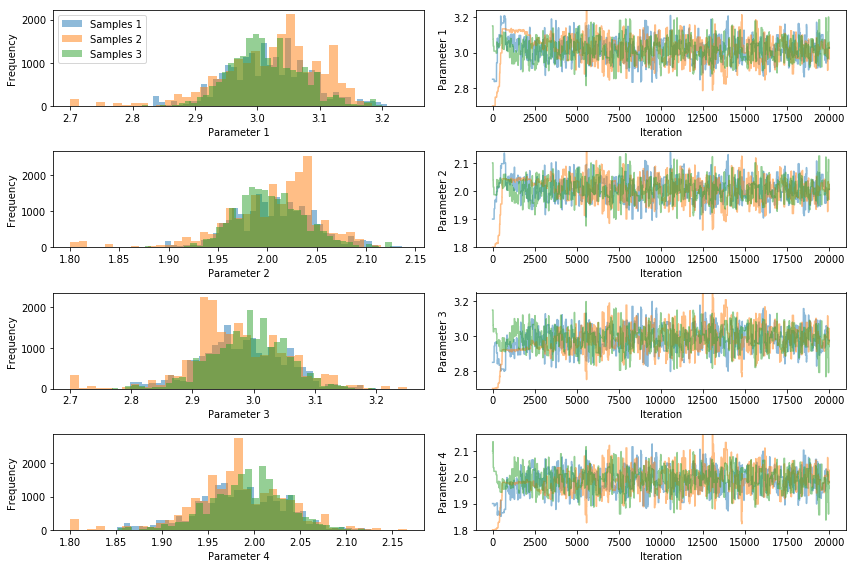

In [22]:
import pints.plot
pints.plot.trace(emu_chains)
plt.show()

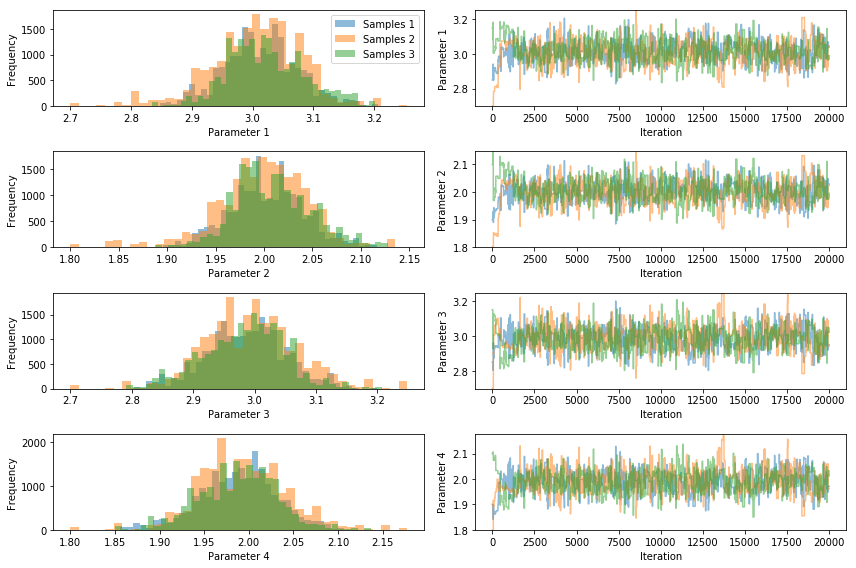

In [23]:
pints.plot.trace(model_chains)
plt.show()

In [24]:
# Look at likelihood changes along one chain
chain = emu_chains[0]
emu_prediction = np.apply_along_axis(emu, 1, chain).flatten()
model_prediction = np.apply_along_axis(real_log_likelihood, 1, chain).flatten()

 /Users/maksympetyak/Prog/pints/pints/emulator/_gp_emulator.py:58: UserWarning:Non-negative log_likelihood predicted. Indicative of high uncertainty in predictions.


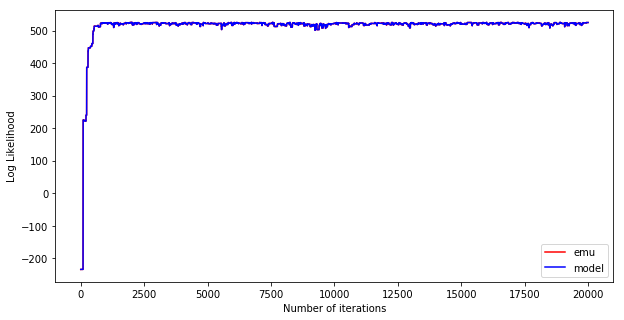

In [25]:
iters = range(len(chain))
plt.figure(figsize=(10, 5))
plt.xlabel("Number of iterations")
plt.ylabel("Log Likelihood")
plt.plot(iters, emu_prediction, color="Red", label='emu')
plt.plot(iters, model_prediction, color="Blue", label='model')
plt.legend()
plt.show()

In [26]:
diffs = np.abs(model_prediction - emu_prediction)

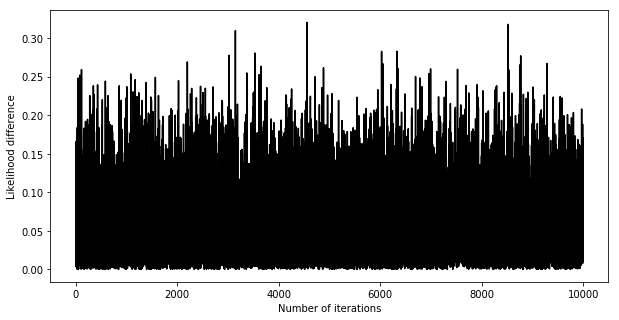

In [27]:
iters = np.linspace(0, 10000, len(chain))
plt.figure(figsize=(10, 5))
plt.xlabel("Number of iterations")
plt.ylabel("Likelihood difference")
plt.plot(iters, diffs, color = "Black")
plt.show()